# Random Generalization

In [124]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision

def create_random_data(n, d, r, mu=0, seed=0):
    """
    This function creates a random data set
    
    Input:
    n - number of samples
    d - dimension of the data
    r - number of non zero entries in the ground truth vector
    mu - mean of the data
    seed - random seed
    
    Output:
    X - data matrix
    y - labels vector
    w_star - ground truth vector
    """
    torch.manual_seed(seed)
    w_star = torch.cat((torch.ones(r), torch.zeros(d-r))) # spares ground truth vector
    X = torch.normal(mu, 1, (n, d))
    y_hat = torch.matmul(X, w_star)
    y = torch.sign(y_hat)
    return X, y, w_star


def create_sparse_labels(X, r):
    """
    This function creates a sparse labels vector
    
    Input:
    X - data matrix
    r - number of non zero entries in the ground truth vector
    
    Output:
    y - labels vector
    w_star - ground truth vector
    """
    d = X.shape[1]
    w_star = torch.cat((torch.ones(r), torch.zeros(d-r))) # spares ground truth vector
    y_hat = torch.matmul(X, w_star)
    y = torch.sign(y_hat)
    return y


def create_data_Mnist(n_train=512, n_test=128, normalized_flag=True, class_A_label=0, class_B_label=1, r=1):
    """
    This function creates a data set from the MNIST dataset. The labels are produced using a sparse ground truth vector with r non zero entries.
    
    Input:
    n_train - number of training samples
    n_test - number of test samples
    normalized_flag - whether to normalize the data
    class_A_label - label of the first class
    class_B_label - label of the second class
    r - number of non zero entries in the ground truth vector
    
    Output:
    x_train - training data
    y_train - training labels
    x_test - test data
    y_test - test labels
    """
    
    train_data = torchvision.datasets.MNIST('./mnist/', train=True, download=True,
                            transform=torchvision.transforms.ToTensor())

    class_A_x = train_data.train_data[train_data.train_labels == class_A_label,:,:].flatten(start_dim=1).to(torch.float32)
    class_B_x = train_data.train_data[train_data.train_labels == class_B_label,:,:].flatten(start_dim=1).to(torch.float32)
    # class_A_y = train_data.train_labels[train_data.train_labels == class_A_label]
    # class_B_y = train_data.train_labels[train_data.train_labels == class_B_label]
    x_train = torch.cat((class_A_x[:n_train//2,:], class_B_x[:n_train//2,:]), 0)
    x_test = torch.cat((class_A_x[n_train//2:n_train//2+n_test//2,:], class_B_x[n_train//2:n_train//2+n_test//2,:]), 0)
    y_train = create_sparse_labels(x_train, r)
    y_test = create_sparse_labels(x_test, r)

    # normalize the data
    if normalized_flag:
        x_train = torch.div(x_train, torch.matmul(torch.norm(x_train, dim=1).view(len(x_train), 1), torch.ones(1, x_train.shape[1])))
        x_test = torch.div(x_test, torch.matmul(torch.norm(x_test, dim=1).view(len(x_test), 1), torch.ones(1, x_test.shape[1])))

    return x_train, y_train, x_test, y_test


def create_sparse_data(n_train, n_test, r=1, dataset="random", seed=0, mu=0, d=50, normalized_flag=True):
        if dataset=="random":
            x_train, y_train, w_star = create_random_data(n_train, d, r, mu, seed)
            x_test, y_test, _ = create_random_data(n_test, d, r, mu, seed)
        elif dataset=="MNIST":
            x_train, y_train, x_test, y_test = create_data_Mnist(n_train, n_test, normalized_flag, class_A_label=0, class_B_label=1, r=r)
        return x_train, y_train, x_test, y_test

class DiagonalNetworks(nn.Module):
    def __init__(self, d_input, depth=2):
        super(DiagonalNetworks, self).__init__()
        self.depth = depth
        self.d_input = d_input
        self.layers = []
        self.layers = nn.Parameter(torch.randn(d_input, depth))
        # for _ in range(depth):
        #     self.layers.append(torch.nn.Linear(d_input, depth, bias=False))
            
    def forward(self, input):
        w = torch.prod(self.layers, axis=1)
        output = torch.matmul(input.float(),w)
        return output
    

class DiagonalNetworks_sampled():
    def __init__(self, dist, d_input, depth=2):
        self.depth = depth
        self.d_input = d_input
        self.dist = dist
        self.w = nn.Parameter(torch.randn(d_input, 1))

    def forward(self, input):
        wx = input*self.w
        output = torch.sum(wx, axis=1)
        return output
    
    def sample_params(self):
        if self.dist=="Normal":
            self.w = np.random.normal(0, 1, (self.d_input))
        elif self.dist=="Normal_uv":
            self.w = np.ones(self.d_input)
            for _ in range(self.depth):
                self.w = np.multiply(self.w, np.random.normal(0, 1, (self.d_input)))
        elif self.dist=="Laplace":
            self.w = np.random.laplace(0, 1, (self.d_input))


def find_interpolating_sol(x_train, y_train, model, number_of_models_to_sample=1000, seed=0):
    """
    This function finds an interpolating model for the given data
    
    Input:
    x_train - training data
    y_train - training labels
    model - model to train
    number_of_models - number of random models to sample
    seed - random seed
    
    Output:
    iter - number of iterations it took to find the interpolating model
    status - "Sucsses" if found an interpolating model, "Failed" otherwise
    """
    np.random.seed(seed)
    for iter in range(number_of_models_to_sample):
        model.sample_params()
        train_acc, _ = calc_accuracy(model, x_train, y_train)
        if train_acc==1.0:
            return iter, "Sucsses"
    return iter, "Failed"


def calc_accuracy(model, X, y):
    """
    This function calculates the accuracy of the model on a given data

    Input:
    model - model to train
    X - data matrix
    y - labels vector

    Output:
    acc - accuracy of the model
    y_hat - predicted labels
    """
    y_hat = model.forward(X)
    predicton = (y_hat*y>0).float()
    acc = torch.sum(predicton)/len(y)
    return acc, y_hat


def calc_guess_and_check_generalzation(x_train, y_train, x_test, y_test, dist="Normal", T_find_interpolating_sol=100000, number_of_GNC_models_to_try=10, seed=0, depth=2):
    """
    This function calculates the avarage generalization of the guess and check algorithm 
    by running the algorithm number_of_GNC_models_to_try times and averaging the resulting models test accuracy
    
    Input:
    x_train - training data
    y_train - training labels
    x_test - test data
    y_test - test labels
    dist - distribution of the weights
    T_find_interpolating_sol - number of random models to sample
    number_of_GNC_models_to_try - number of models to (try to) obtain using the guess and check algorithm
    seed - random seed
    depth - depth of the model
    
    Output:
    test_acc_mean - avarage test accuracy of the models
    test_acc_std - standard deviation of the test accuracy of the models
    succ_counter - number of models that were trained successfully
    """
    d = x_train.shape[1]
    succ_counter = 0
    test_acc_vec = []
    model = DiagonalNetworks_sampled(dist, d, depth=depth)
    for i in range(number_of_GNC_models_to_try):
        iter, status = find_interpolating_sol(x_train, y_train, model, T_find_interpolating_sol, seed+i)
        if status=="Failed":
            continue
        succ_counter += 1
        test_acc, _ = calc_accuracy(model, x_test, y_test)
        test_acc_vec.append(test_acc)
    if (len(test_acc_vec)):
        test_acc_mean = np.array(test_acc_vec).mean()
        test_acc_std = np.array(test_acc_vec).std()
    return test_acc_mean, test_acc_std, succ_counter


def train_gd(model, optimizer, criterion, x_train, y_train, epochs=1000, loss_thr=1e-3 ,print_loss=True):
    """
    This function trains a given model using gradient descent
    
    Input:
    model - model to train
    optimizer - optimizer to use
    criterion - loss function
    x_train - training data
    y_train - training labels
    epochs - number of epochs to train
    loss_thr - loss threshold to stop training (only if the training accuracy is 1.0)
    print_loss - whether to print the loss during training
    
    Output:
    iter - number of iterations it took to find the interpolating model
    status - "Sucsses" if found an interpolating model, "Failed" otherwise
    """
    for iter in range(epochs):
        model.train()
        optimizer.zero_grad()
        train_acc, y_hat = calc_accuracy(model, x_train, y_train)
        loss_train = criterion(y_hat, (y_train>0).float())

        loss_train.backward()
        optimizer.step()
        if iter%100 == 0 and print_loss:
            print(f"iter:{iter}, Training loss:{loss_train}, Training accuracy:{train_acc}")
        if train_acc==1.0 and loss_train<loss_thr:
            return iter, "Sucsses"
    return iter, "Failed"


def calc_GD_generalzation(x_train, y_train, x_test, y_test, lr=0.1, number_of_models_to_try=10, epochs=1000, loss_thr=1e-3):
    """
    This function calculates the avarage generalization of the gradient descent algorithm 
    by running the algorithm number_of_models times and averaging the resulting models test accuracy
    
    Input:
    x_train - training data
    y_train - training labels
    x_test - test data
    y_test - test labels
    lr - learning rate
    number_of_models - number of models to train
    epochs - number of epochs to train
    loss_thr - loss threshold to stop training (only if the training accuracy is 1.0)
    
    Output:
    test_acc_mean - avarage test accuracy of the models
    test_acc_std - standard deviation of the test accuracy of the models
    succ_counter - number of models that were trained successfully
    """
    d = x_train.shape[1]
    succ_counter = 0
    test_acc_vec = []
    for i in range(number_of_models_to_try):
        if i%50==0:
            print(f"Initializing model number {i}")
        model_gd = DiagonalNetworks(d)
        optimizer = torch.optim.SGD(model_gd.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()
        iter, status = train_gd(model_gd, optimizer, criterion, x_train, y_train, epochs=epochs, loss_thr=loss_thr, print_loss=False)
        if status=="Failed":
            continue
        succ_counter += 1
        test_acc, _ = calc_accuracy(model_gd, x_test, y_test)
        test_acc_vec.append(test_acc)
    if (len(test_acc_vec)):
        test_acc_mean = np.array(test_acc_vec).mean()
        test_acc_std = np.array(test_acc_vec).std()
    return test_acc_mean, test_acc_std, succ_counter

In [137]:
r_vec = np.arange(1, 10, 2)
r_vec = [3]
mu = 0
dataset = "random"
N_train, N_test, d = 2, 10, 50
# N_train, N_test, d = 10, 10, 30
# N_train, N_test, d = 25, 10, 50
T_find_interpolating_sol = 1000000
number_of_GNC_models_to_try = 1000
seed_vec = np.arange(50)
seed_vec = np.arange(10)
# seed_vec = [1]
dist_vec = ["Normal", "Normal_uv", "Laplace"]
# dist_vec = ["Normal_uv"]
depth = 2
mean_test_acc_dict = {}
std_test_acc_dict = {}
test_acc_dict = {}
test_acc_dict =	{
  "Normal": [],
  "Normal_uv": [],
  "Laplace": []
}
for r in r_vec:
  for seed in seed_vec:
    x_train, y_train, x_test, y_test = create_sparse_data(n_train=N_train, n_test=N_test, r=r, dataset=dataset, normalized_flag=False, seed=seed, mu=mu, d=d)
    for dist in dist_vec:
          if seed%25==0:
            print(f"r={r}, seed={seed}, dist={dist}")
          test_acc, test_acc_std, _ = calc_guess_and_check_generalzation(x_train, y_train, x_test, y_test, dist,  T_find_interpolating_sol, number_of_GNC_models_to_try, seed, depth=depth)
          test_acc_dict[dist].append(test_acc)

  for dist in dist_vec:
      print(dist, np.array(test_acc_dict[dist]).mean())
      mean_test_acc_dict[(r, dist)] = np.array(test_acc_dict[dist]).mean()
      std_test_acc_dict[(r, dist)] = np.array(test_acc_dict[dist]).std()

r=3, seed=0, dist=Normal
r=3, seed=0, dist=Normal_uv
r=3, seed=0, dist=Laplace
Normal 0.58919007
Normal_uv 0.58608997
Laplace 0.58801997


In [16]:
_

10000

In [138]:
std_test_acc_dict

{(3, 'Normal'): 0.017540837,
 (3, 'Normal_uv'): 0.0184942,
 (3, 'Laplace'): 0.018344734}

In [139]:
test_acc_std

0.15363124

In [32]:
test_acc, test_acc_std, _ = calc_GD_generalzation(x_train, y_train, x_test, y_test, lr=1e-3, number_of_models_to_try=number_of_GNC_models_to_try, epochs=1000, loss_thr=10)

Initializing model number 0
Initializing model number 50
Initializing model number 100
Initializing model number 150
Initializing model number 200
Initializing model number 250
Initializing model number 300
Initializing model number 350
Initializing model number 400
Initializing model number 450
Initializing model number 500
Initializing model number 550
Initializing model number 600
Initializing model number 650
Initializing model number 700
Initializing model number 750
Initializing model number 800
Initializing model number 850
Initializing model number 900
Initializing model number 950


In [33]:
test_acc


0.74159575

In [34]:
test_acc_std

0.12472781

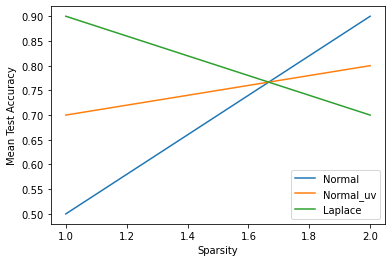

In [8]:
for dist in ["Normal", "Normal_uv", "Laplace"]:
    mean_test_acc_vec = [mean_test_acc_dict[(r, dist)] for r in r_vec]
    plt.plot(r_vec, mean_test_acc_vec, label=dist)

plt.xlabel("Sparsity")
plt.ylabel("Mean Test Accuracy")
# plt.yscale("log")
plt.legend()
# plt.show()
if len(seed_vec)==1:
    plt.savefig(f"Figures/diagonal_networks_random_generalization_N_train={N_train}_N_test={N_test}_d={d}_mu={mu}_seed={seed_vec[0]}.png")
else:
    plt.savefig(f"Figures/diagonal_networks_random_generalization_N_train={N_train}_N_test={N_test}_d={d}_mu={mu}_seed_num={len(seed_vec)}.png")


# NEW

In [2]:
import numpy as np
from create_data import create_sparse_data
from guess_n_check import calc_guess_and_check_generalzation
from gd import calc_GD_generalzation
from matplotlib import pyplot as plt
import torch.nn as nn

r_vec = np.arange(1, 10, 2)
r_vec = [1]
mu = 0
dataset = "random"
# N_train, N_test, d = 2, 10, 50
# N_train, N_test, d = 10, 10, 30
# N_train, N_test, d = 25, 10, 50
N_train, N_test, d = 12, 6, 25
criterion = nn.BCEWithLogitsLoss()
T_find_interpolating_sol = 1000000
number_of_GNC_models_to_try = 1000
gd_epochs = 1000
loss_max_thr = 0.3
loss_min_thr = 0.2
gd_lr = 1e-3
seed_vec = np.arange(50)
seed_vec = np.arange(10)
# seed_vec = [1]
dist_vec = ["Normal", "Normal_uv", "Laplace"]
# dist_vec = ["Normal_uv"]
depth = 10
mean_test_acc_dict = {}
std_test_acc_dict = {}
test_acc_dict = {}
test_acc_dict =	{
  "Normal": [],
  "Normal_uv": [],
  "Laplace": [],
  "GD": []
}
for r in r_vec:
    for seed in seed_vec:
        x_train, y_train, x_test, y_test = create_sparse_data(n_train=N_train, n_test=N_test, r=r, dataset=dataset, normalized_flag=False, seed=seed, mu=mu, d=d)
        for dist in dist_vec:
            if seed%25==0:
                print(f"r={r}, seed={seed}, dist={dist}")
            test_acc_mean, test_acc_std, _ = calc_guess_and_check_generalzation(x_train, y_train, x_test, y_test, dist,  T_find_interpolating_sol, number_of_GNC_models_to_try, seed, depth=depth, criterion=criterion, loss_max_thr=loss_max_thr, loss_min_thr=loss_min_thr)
            test_acc_dict[dist].append(test_acc_mean)

        if seed%25==0:
            print(f"r={r}, seed={seed}, GD")
        test_acc_mean, test_acc_std, _ = calc_GD_generalzation(x_train, y_train, x_test, y_test, lr=gd_lr, number_of_models_to_try=number_of_GNC_models_to_try, epochs=gd_epochs, loss_max_thr=loss_max_thr, loss_min_thr=loss_min_thr)
        test_acc_dict["GD"].append(test_acc_mean)
        
    for dist in ["Normal", "Normal_uv", "Laplace", "GD"]:
        print(dist, np.array(test_acc_dict[dist]).mean())
        mean_test_acc_dict[(r, dist)] = np.array(test_acc_dict[dist]).mean()
        std_test_acc_dict[(r, dist)] = np.array(test_acc_dict[dist]).std()

r=1, seed=0, dist=Normal
GNC: Trying model 0 out of 1000


KeyboardInterrupt: 

In [25]:
test_acc_mean, test_acc_std, _ = calc_GD_generalzation(x_train, y_train, x_test, y_test, lr=100*gd_lr, number_of_models_to_try=10, epochs=10*gd_epochs, loss_max_thr=0.05, loss_min_thr=0)

GD: Initializing model number 0


KeyboardInterrupt: 

In [ ]:
test_acc_mean

0.8166666

array([], dtype=int64)

In [3]:
mean_test_acc_dict

{(3, 'Normal'): 0.53031,
 (3, 'Normal_uv'): 0.53466,
 (3, 'Laplace'): 0.53108996,
 (3, 'GD'): 0.51123005}

In [4]:
std_test_acc_dict

{(3, 'Normal'): 0.03092378,
 (3, 'Normal_uv'): 0.033332024,
 (3, 'Laplace'): 0.03337513,
 (3, 'GD'): 0.012701888}

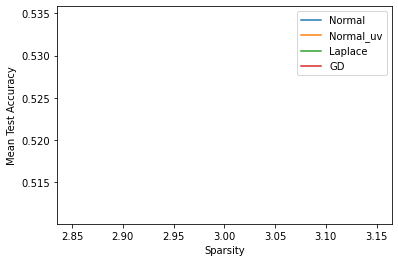

In [5]:
for dist in ["Normal", "Normal_uv", "Laplace", "GD"]:
    mean_test_acc_vec = [mean_test_acc_dict[(r, dist)] for r in r_vec]
    plt.plot(r_vec, mean_test_acc_vec, label=dist)

plt.xlabel("Sparsity")
plt.ylabel("Mean Test Accuracy")
# plt.yscale("log")
plt.legend()
# plt.show()
if len(seed_vec)==1:
    plt.savefig(f"Figures/diagonal_networks_random_generalization_N_train={N_train}_N_test={N_test}_d={d}_mu={mu}_seed={seed_vec[0]}.png")
else:
    plt.savefig(f"Figures/diagonal_networks_random_generalization_N_train={N_train}_N_test={N_test}_d={d}_mu={mu}_seed_num={len(seed_vec)}.png")

# print("GD", test_acc, test_acc_std)

# Plots

In [20]:
import torch

# load baselines
def load_baseline(args, r):
        mean_test_acc_baseline = {}
        std_test_acc_baseline = {}
        for reg in ["L1", "L2", "null"]:
                file_name = f"N_train={args.N_train}_N_test={args.N_test}_dataset={args.dataset}_d={args.d}_mu={args.mu}_seed_num={args.seed_num}_r={r}_reg={reg}"
                res = torch.load(f"{args.results_folder}/{file_name}.pt")
                mean_test_acc_baseline[(r, reg)] = res["mean_test_acc"]
                std_test_acc_baseline[(r, reg)] = res["std_test_acc"]
        return mean_test_acc_baseline, std_test_acc_baseline

Results/mean_test_acc_dict_N_train=16_N_test=2000_dataset=random_d=30_mu=0_seed_num=10_T_find_interpolating_sol=100000_number_of_GNC_models_to_try=100_gd_epochs=10000_gd_lr=0.1_loss_max_thr=0.3_loss_min_thr=0.2_depth=30.pkl


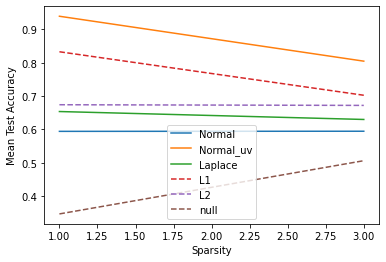

In [25]:
from utilities import get_file_name
import pickle
import argparse

args = argparse.Namespace()
args.N_train = 16
args.N_test = 2000
args.dataset = "random"
args.d = 30
args.mu = 0
args.seed_num = 10
args.T_find_interpolating_sol = 100000
args.number_of_GNC_models_to_try = 100
args.gd_epochs = 10000
args.gd_lr = 0.1
args.weight_decay = 0.0
args.loss_max_thr = 0.3
args.loss_min_thr = 0.2
args.depth = 30
args.results_folder = "Results"

print(get_file_name("mean_test_acc_dict", args))

with open(get_file_name("mean_test_acc_dict", args, checkpoint=True), 'rb') as f:
        mean_test_acc = pickle.load(f)

r_vec = [1, 3]
mean_test_acc_baseline_dict = {}
for r in r_vec:
        mean_test_acc_baseline, std_test_acc_baseline = load_baseline(args, r)
        mean_test_acc_baseline_dict.update(mean_test_acc_baseline)

# plot results
import matplotlib.pyplot as plt

dist_vec = ["Normal", "Normal_uv", "Laplace"]
for dist in dist_vec:
        mean_test_acc_vec = [mean_test_acc[(r, dist)] for r in r_vec]
        plt.plot(r_vec, mean_test_acc_vec, label=dist)

for reg in ["L1", "L2", "null"]:
        mean_test_acc_vec = [mean_test_acc_baseline_dict[(r, reg)] for r in r_vec]
        plt.plot(r_vec, mean_test_acc_vec, "--", label=reg)

plt.xlabel("Sparsity")
plt.ylabel("Mean Test Accuracy")
plt.legend()

In [22]:
mean_test_acc_baseline

{(1, 'L1'): 0.833, (1, 'L2'): 0.67419994, (1, 'null'): 0.34690002}